In [1]:
!pip install scipy==1.14.1 statsmodels==0.14.2 numpy==2.0.1

In [2]:
import os
from pathlib import Path
import sys

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import statsmodels.api as sm

## 1. Data Load

In [5]:
def load_gus_monthly_inflation_data() -> pd.DataFrame:
    data = pd.read_csv(
        Path(os.getcwd()) / "data" / "monthly_GUS_data_EoY2023.csv",
        sep=";", decimal=",", index_col=None, na_values="."
    )
    data["yearmon"] = pd.to_datetime(data["yearmon"], format="%d.%m.%Y")
    data = data.set_index("yearmon")
    data["mom"] = data["CPI_inflation_MoM"] - 100
    data["yoy"] = data["CPI_inflation_YoY"] - 100
    return data[["mom", "yoy"]]

In [6]:
data = load_gus_monthly_inflation_data()

In [7]:
data

,mom,yoy
yearmon,,
2000-01-01,1.8,10.1
2000-02-01,0.9,10.4
2000-03-01,0.9,10.3
2000-04-01,0.4,9.8
2000-05-01,0.7,10.0
...,...,...
2023-08-01,0.0,10.1
2023-09-01,-0.4,8.2
2023-10-01,0.3,6.6


## 2. Inflation Overview

In [8]:
fig_inflation = plt.figure(figsize=(10, 5))
fig_inflation.suptitle("CPI Inflation - GUS Data, MoM and YoY Rates", size=16)

Text(0.5, 0.98, 'CPI Inflation - GUS Data, MoM and YoY Rates')

<Figure size 1000x500 with 0 Axes>

In [9]:
ax_mom, ax_yoy = fig_inflation.subplots(2, 1, sharex=True)

In [10]:
ax_mom.set_title("MoM Values", size=12)
ax_yoy.set_title("YoY Values", size=12)

Text(0.5, 1.0, 'YoY Values')

In [11]:
ax_mom.plot(data.index, data["mom"])
ax_mom.grid(linestyle="dashed")
ax_yoy.plot(data.index, data["yoy"])
ax_yoy.grid(linestyle="dashed")

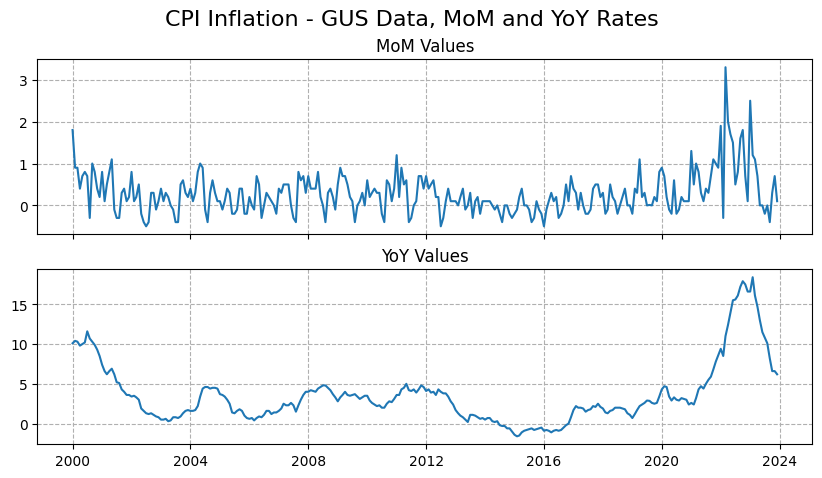

In [12]:
fig_inflation

## 3. ACF and PACF functions for MoM Inflation Rate

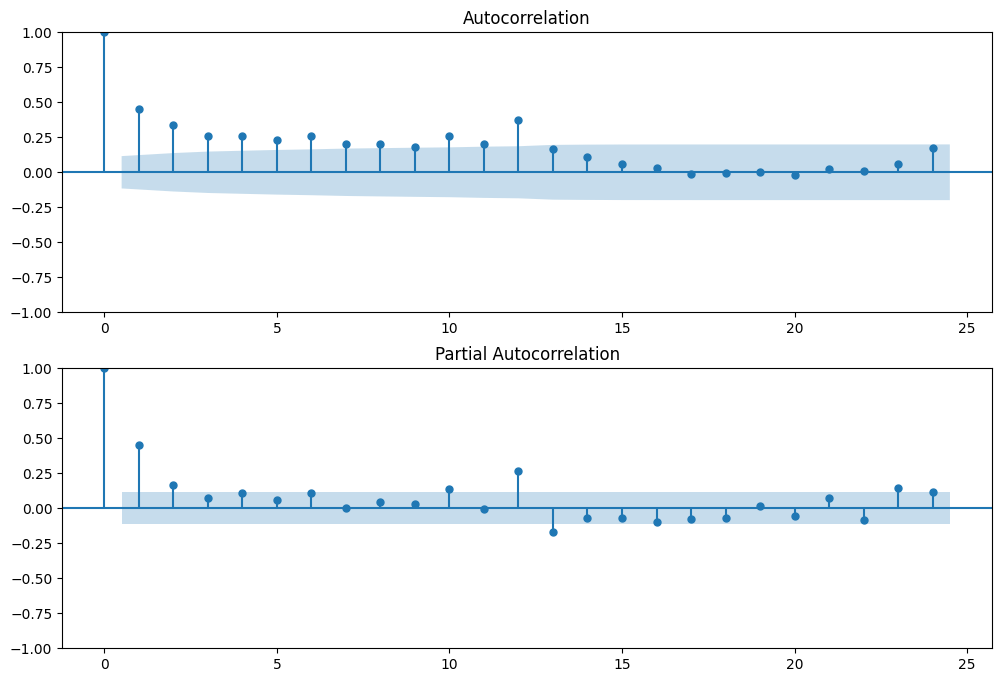

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data["mom"].values.squeeze(), lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data["mom"], lags=24, ax=ax2)

## 4. Fitting AR Model to MoM Inflation Rate

Note: the lags of this autoregressive model have been selected rather arbirarily based on the ACF plot

In [23]:
ar_model = sm.tsa.arima.ARIMA(data["mom"].values, order=([1, 2, 12], 0, 0))
ar_model_fit_results = ar_model.fit()

In [24]:
ar_model_fit_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:                           y   No. Observations:                  288
Model:             ARIMA([1, 2, 12], 0, 0)   Log Likelihood                -151.695
Date:                     Thu, 12 Sep 2024   AIC                            313.390
Time:                             23:04:56   BIC                            331.704
Sample:                                  0   HQIC                           320.729
                                     - 288                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3216      0.112      2.866      0.004       0.102       0.541
ar.L1          0.3475      0.047      7.452      0.000       0.256       0.439
ar.L2          0.1070      0.044      2.439      0.015       0.021       0.193
ar.L12         0.3172      0.041      7.729      0.000       0.237       0.398
sigma2         0.1668      0.010     16.056      0.000       0.146       0.187
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):               936.49
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                             1.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Useful reference

Reference concerning selection of the AR and MA lags based on ACF and PACF plots [is available here](https://people.duke.edu/~rnau/411arim3.htm)